---
1. datetime으로 부터 필요한 변수 year, month, hour, weekday 추출 
2. 불필요한 변수 제거
3. train / test dateset 분리 
4. Linear Regression & Random Forest modeling 
---

In [29]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

data_path = 'kaggle/input/bike-sharing-demand/'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

print(train.shape, test.shape, submission.shape)

(10886, 12) (6493, 9) (6493, 2)


In [30]:
#EDA과정에서 발견된 특이값 제거(weather = 4)
train = train[train['weather'] !=4]

#train, test 모두에 전처리 적용을 위해 데이터 합침 
all_data = pd.concat([train, test], ignore_index=True) 

#datetime으로 부터 연/월/시간/요일 추출 
from datetime import datetime
all_data['datetime'] = pd.to_datetime(all_data['datetime'])
all_data['year'] = all_data['datetime'].dt.year
all_data['month'] = all_data['datetime'].dt.month
all_data['hour'] = all_data['datetime'].dt.hour
all_data['weekday'] = all_data['datetime'].dt.weekday

#불필요한 변수 제거 
#datetime -> year, month, hour, weekday 변수가 생성되었으므로 불필요 
#windspeed -> EDA 결과  y(대여량)과 상관관계가 매우 낮음
#month -> season 변수로써 충분히 설명됨 
#causal, registered(비회원,회원 여부) -> train에만 존재하고 test에는 없는 변수  

drop_features = ['datetime', 'month', 'windspeed', 'casual', 'registered']
all_data = all_data.drop(drop_features, axis=1)

all_data

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,0,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,1,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,2,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,3,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,4,5
...,...,...,...,...,...,...,...,...,...,...,...
17373,1,0,1,2,10.66,12.880,60,NaN,2012,19,0
17374,1,0,1,2,10.66,12.880,60,NaN,2012,20,0
17375,1,0,1,1,10.66,12.880,60,NaN,2012,21,0
17376,1,0,1,1,10.66,13.635,56,NaN,2012,22,0


In [31]:
#다시 train, test 데이터셋 나눔 (count값이 존재하면 train, 존재하지 않으면 test)
#target변수인 count 제거, count는 별도의 변수 y에 따로 할당 
X_train = all_data[~pd.isnull(all_data['count'])]
X_train = X_train.drop(['count'], axis=1)

X_test = all_data[pd.isnull(all_data['count'])]
X_test = X_test.drop(['count'], axis=1)

y=train['count']

In [32]:
print(X_train.shape)
X_train.head()

(10885, 10)


,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,0,5
1,1,0,0,1,9.02,13.635,80,2011,1,5
2,1,0,0,1,9.02,13.635,80,2011,2,5
3,1,0,0,1,9.84,14.395,75,2011,3,5
4,1,0,0,1,9.84,14.395,75,2011,4,5


In [33]:
print(X_test.shape)
X_test.head()

(6493, 10)


,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
10885,1,0,1,1,10.66,11.365,56,2011,0,3
10886,1,0,1,1,10.66,13.635,56,2011,1,3
10887,1,0,1,1,10.66,13.635,56,2011,2,3
10888,1,0,1,1,10.66,12.880,56,2011,3,3
10889,1,0,1,1,10.66,12.880,56,2011,4,3


In [34]:
print(y.shape)
y.head()

(10885,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

---

In [35]:
#Linear Regression modeling 
from sklearn.linear_model import LinearRegression
model_a = LinearRegression()

#EDA 과정에서 target값의 분포가 좌편향되었음을 발견 --> 로그변환 필요
log_y = np.log(y)

#model training 
model_a.fit(X_train, log_y)

#모형의 설명력 계산 
print('R_squre = ', model_a.score(X_train, log_y) )

#RMSLE 계산 
from sklearn.metrics import mean_squared_log_error

log_y_pred = model_a.predict(X_train)
y_pred = np.exp(log_y_pred)
y_true = np.exp(log_y)

rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
print('RMSLE = ', rmsle)

R_squre =  0.47974689600316167
RMSLE =  1.0204980189305022


In [36]:
#test data에 대해 model_a 적용하여 예측값을 취한 후, kaggle 제출용 파일 만들기 
preds = model_a.predict(X_test)

submission['count'] = np.exp(preds)
submission.to_csv('submission.csv', index=False)

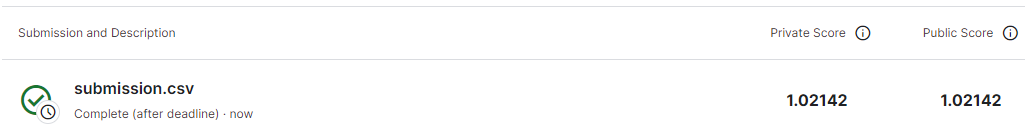

In [37]:
from IPython.display import Image
Image("images/model_a.score.PNG")

---

In [38]:
#Random Forest modeling 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_log_error, r2_score
import numpy as np

# RMSLE 함수를 정의하고, RMSLE score 생성
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

# Random Forest 모델 및 그리드 서치 설정
model_b = RandomForestRegressor()
params = {'n_estimators': [100, 120, 140], 'random_state': [42]}
gs_model = GridSearchCV(estimator=model_b, 
                        param_grid=params, 
                        scoring=rmsle_scorer, 
                        cv=5)

# 타겟값 로그 변환
log_y = np.log(y)

# Grid Search 실행
gs_model.fit(X_train, log_y)
print('Optimized hyperparameter = ', gs_model.best_params_)

# 최적의 모델로 예측값 구하기
log_y_pred = gs_model.predict(X_train)

# 예측값을 원래 스케일로 변환
y_pred = np.exp(log_y_pred)
y_true = np.exp(log_y)

# 설명력 R^2 계산
r2 = r2_score(y_true, y_pred)
print('R^2:', r2)

# RMSLE 계산
rmsle_value = rmsle(y_true, y_pred)
print('RMSLE:', rmsle_value)


Optimized hyperparameter =  {'n_estimators': 100, 'random_state': 42}
R^2: 0.9917468650489588
RMSLE: 0.11378112201911154


In [39]:
#test data에 대해 model을 적용하여 예측값을 취한 후, kaggle 제출용 파일 만들기 
final_preds = gs_model.best_estimator_.predict(X_test) 

submission['count'] = np.exp(final_preds)
submission.to_csv('submission.csv', index=False)

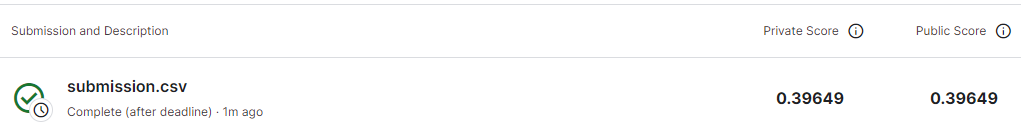

In [41]:
Image("images/model_RF.score.PNG")

---
- Random Forest가 앞도적으로 높은 성능을 보여주었다. 
  - Regression 의 결과 : 모형 설명력 48%, RMSLE 1.020 --> kaggle 평가 RMSLE = 1.021
  - Random Forest 결과 : 모형 설명력 99%, RMSLE 0.113 --> kaggle 평가 RMSLE = 0.396 
---